<a href="https://colab.research.google.com/github/sofiaangulodiaz/HE-IA---PARCIAL-2---GRUPO-3---Prediccion-de-Ingresos-con-Datos-del-Censo/blob/main/parcial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.1 Carga robusta y limpieza mínima

Decisiones: estandarizo nombres/columnas, convierto “?” en NA, elimino espacios, binarizo la etiqueta income (>50K→1, ≤50K→0). Para adult.test remuevo el punto final estándar.

In [ ]:
import copy
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch, torch.nn as nn, torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ── Reproducibilidad y dispositivo ────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
warnings.filterwarnings("ignore", category=FutureWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Esquema de columnas canónico (Adult UCI) ──────────────────────────────────
expected_cols = [
    'age','workclass','fnlwgt','education','education-num','marital-status',
    'occupation','relationship','race','sex','capital-gain','capital-loss',
    'hours-per-week','native-country','income'
]

# ── Función de carga robusta (maneja .data y .test) ───────────────────────────
def load_adult(path:str, is_test:bool=False) -> pd.DataFrame:
    """
    Carga un archivo Adult UCI y:
      - asigna nombres de columnas si no hay header,
      - mapea '?' a NA,
      - remueve espacios en variables string,
      - binariza 'income' como {0,1} y quita '.' del .test.
    """
    df = pd.read_csv(
        path,
        header=None,
        names=expected_cols,
        na_values=['?'],
        skiprows=1 if is_test else 0  # adulto.test suele tener 1 línea inicial no útil
    )
    # Normalización de espacios
    for c in df.columns:
        if df[c].dtype == 'object':
            df[c] = df[c].astype(str).str.strip()
    # Binarización de etiqueta
    if 'income' in df:
        if is_test:
            df['income'] = df['income'].str.replace('.', '', regex=False)
        df['income'] = (df['income'].str.contains('>50K')).astype(int)
    return df


1.2 División correcta sin fuga de información (train desde .data; val/test 50/50 desde .test)

Regla del enunciado: partir .test en validación y prueba (50/50, estratificado). Motivo: mantener proporción de clases y garantizar evaluación honesta.

In [ ]:
# ── TRAIN desde adult.data ────────────────────────────────────────────────────
df_train = load_adult('/content/sample_data/adult.data', is_test=False)
y_train = df_train['income'].copy()
x_train = df_train.drop(columns=['income']).copy()
print("TRAIN (adult.data):", x_train.shape,
      "| income distrib:", y_train.value_counts(normalize=True).round(3).to_dict())

# ── Cargar adult.test crudo y dividir 50/50 → VAL y TEST ─────────────────────
df_testfull = load_adult('/content/sample_data/adult.test', is_test=True)
y_tmp = df_testfull['income'].copy()
x_tmp = df_testfull.drop(columns=['income']).copy()

x_val, x_test, y_val, y_test = train_test_split(
    x_tmp, y_tmp,
    test_size=0.5, stratify=y_tmp, random_state=SEED
)
print("VAL (adult.test 50%):", x_val.shape,
      "| income distrib:", y_val.value_counts(normalize=True).round(3).to_dict())
print("TEST(adult.test 50%):", x_test.shape,
      "| income distrib:", y_test.value_counts(normalize=True).round(3).to_dict())


TRAIN (adult.data): (32561, 14) | income distrib: {0: 0.759, 1: 0.241}
VAL (adult.test 50%): (8140, 14) | income distrib: {0: 0.764, 1: 0.236}
TEST(adult.test 50%): (8141, 14) | income distrib: {0: 0.764, 1: 0.236}


1.3 Exploratory Data Analysis (EDA) solo con TRAIN (evita leakage)

Decisiones: toda la exploración (nulos, distribuciones, relaciones con la etiqueta) se hace solo con training. Validación/Test solo verifican la estratificación.

Valores nulos por columna (TRAIN):
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64


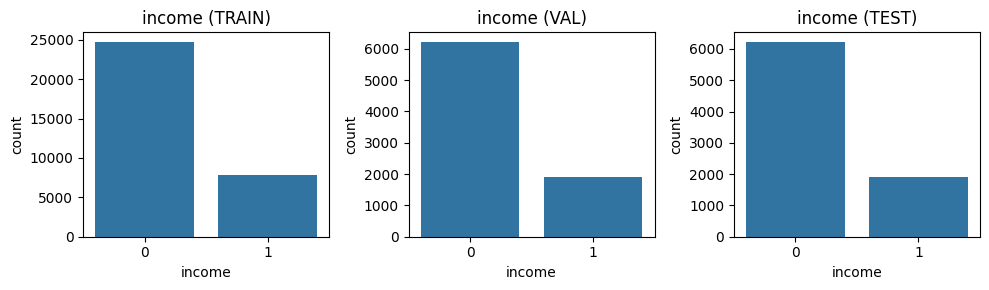

Proporciones income TRAIN:
 income
0    0.759
1    0.241
Name: proportion, dtype: float64
Proporciones income VAL:
 income
0    0.764
1    0.236
Name: proportion, dtype: float64
Proporciones income TEST:
 income
0    0.764
1    0.236
Name: proportion, dtype: float64


,count,mean,std,min,1%,5%,50%,95%,99%,max
age,32561.0,38.581647,13.640433,17.0,17.0,19.0,37.0,63.0,74.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,27185.8,39460.0,178356.0,379682.0,510072.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,3.0,5.0,10.0,14.0,16.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,5013.0,15024.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,0.0,1980.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,8.0,18.0,40.0,60.0,80.0,99.0


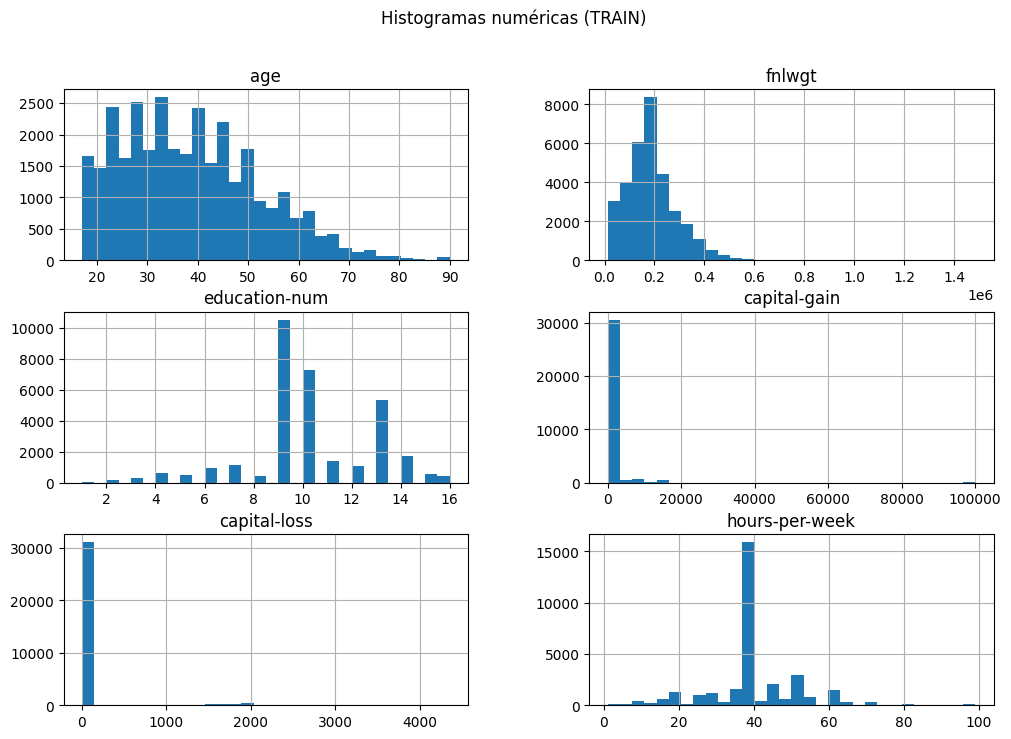

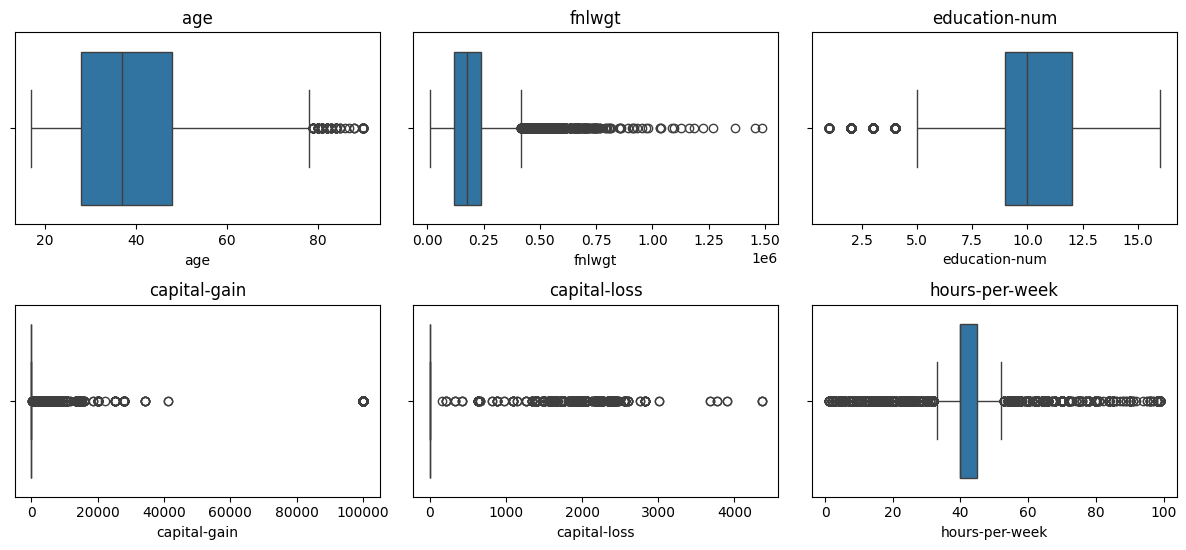

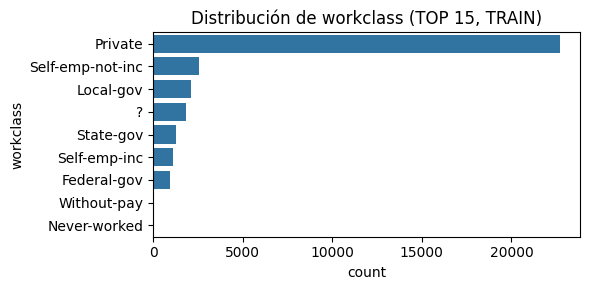

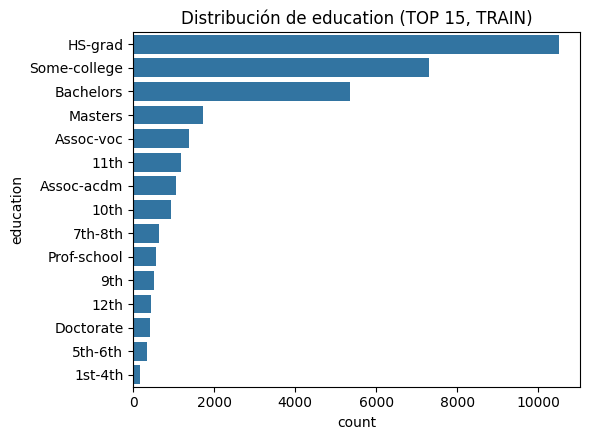

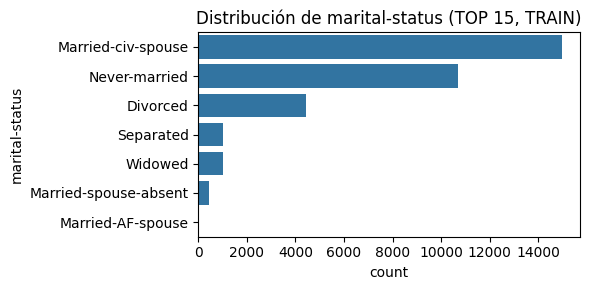

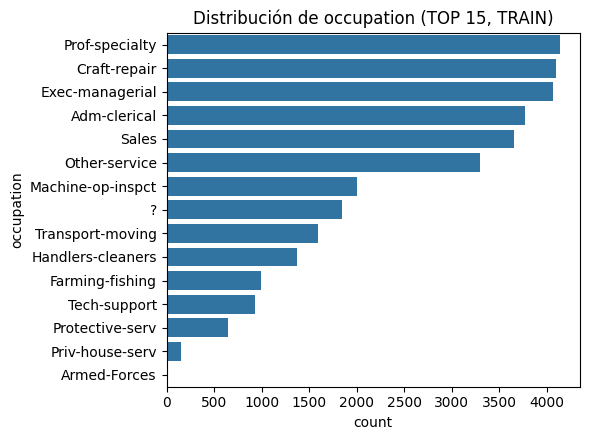

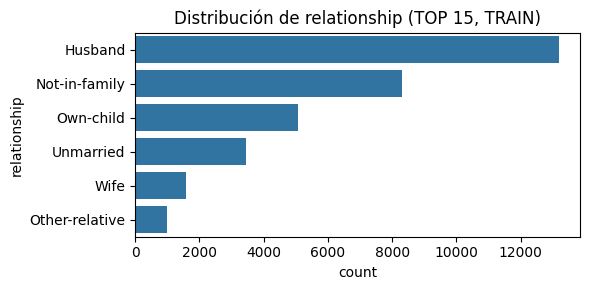

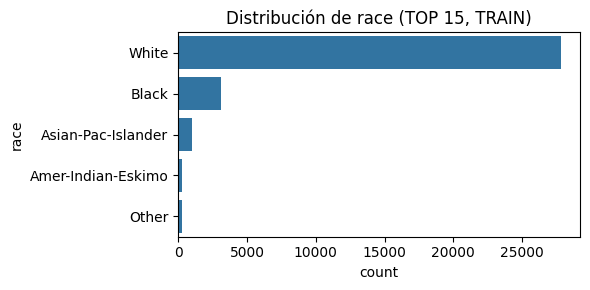

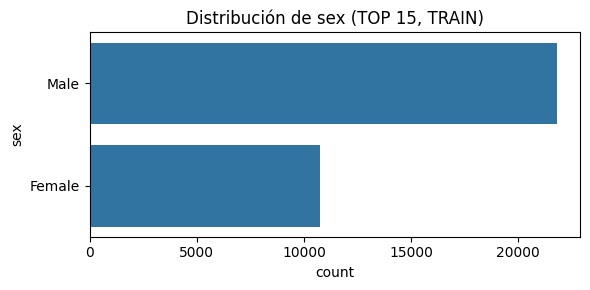

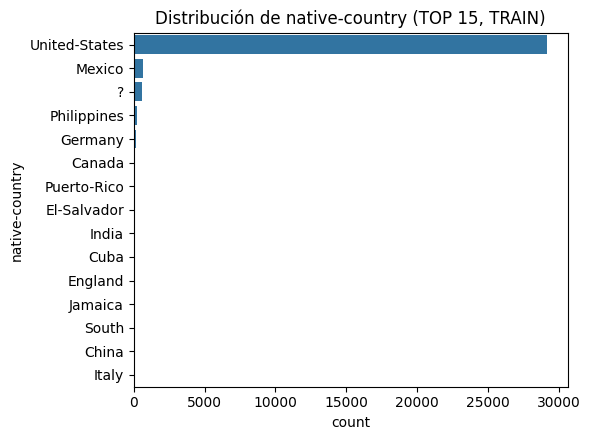

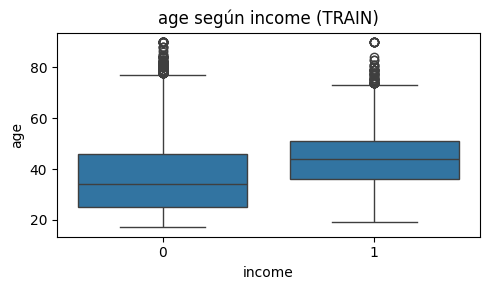

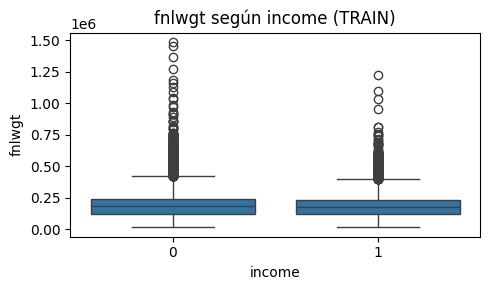

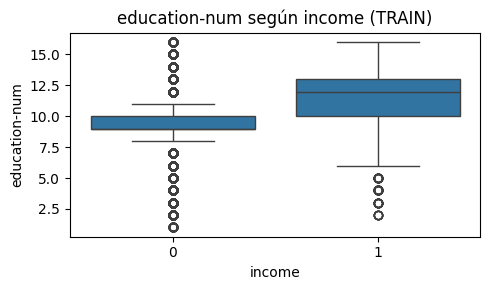

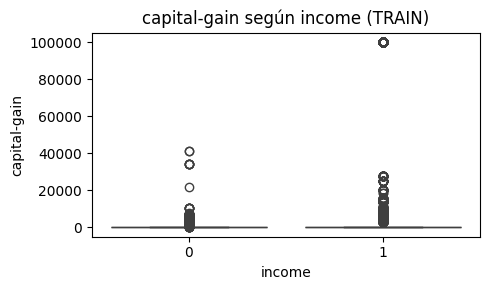

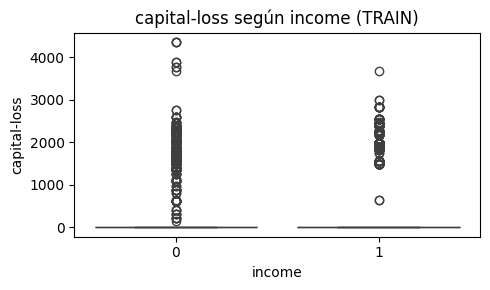

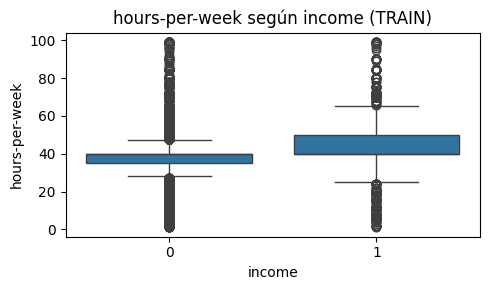


% income=1 dentro de workclass (TRAIN, min 100 obs):


,0,1
workclass,,
Self-emp-inc,44.265233,55.734767
Federal-gov,61.354167,38.645833
Local-gov,70.520784,29.479216
Self-emp-not-inc,71.507281,28.492719
State-gov,72.804314,27.195686
Private,78.132711,21.867289
?,89.596950,10.403050



% income=1 dentro de education (TRAIN, min 100 obs):


,0,1
education,,
Doctorate,25.907990,74.092010
Prof-school,26.562500,73.437500
Masters,44.341265,55.658735
Bachelors,58.524743,41.475257
Assoc-voc,73.878437,26.121563
Assoc-acdm,75.164011,24.835989
Some-college,80.976546,19.023454
HS-grad,84.049138,15.950862
12th,92.378753,7.621247



% income=1 dentro de marital-status (TRAIN, min 100 obs):


,0,1
marital-status,,
Married-civ-spouse,55.315171,44.684829
Divorced,89.579113,10.420887
Widowed,91.440081,8.559919
Married-spouse-absent,91.866029,8.133971
Separated,93.560976,6.439024
Never-married,95.403913,4.596087



% income=1 dentro de occupation (TRAIN, min 100 obs):


,0,1
occupation,,
Exec-managerial,51.598623,48.401377
Prof-specialty,55.096618,44.903382
Protective-serv,67.488444,32.511556
Tech-support,69.504310,30.495690
Sales,73.068493,26.931507
Craft-repair,77.335936,22.664064
Transport-moving,79.962430,20.037570
Adm-clerical,86.551724,13.448276
Machine-op-inspct,87.512488,12.487512



% income=1 dentro de relationship (TRAIN, min 100 obs):


,0,1
relationship,,
Wife,52.487245,47.512755
Husband,55.142879,44.857121
Not-in-family,89.692956,10.307044
Unmarried,93.673825,6.326175
Other-relative,96.228338,3.771662
Own-child,98.677979,1.322021



% income=1 dentro de race (TRAIN, min 100 obs):


,0,1
race,,
Asian-Pac-Islander,73.435996,26.564004
White,74.414006,25.585994
Black,87.612036,12.387964
Amer-Indian-Eskimo,88.424437,11.575563
Other,90.774908,9.225092



% income=1 dentro de sex (TRAIN, min 100 obs):


,0,1
sex,,
Male,69.426342,30.573658
Female,89.053941,10.946059



% income=1 dentro de native-country (TRAIN, min 100 obs):


,0,1
native-country,,
India,60.000000,40.000000
Canada,67.768595,32.231405
Germany,67.883212,32.116788
Philippines,69.191919,30.808081
?,74.957118,25.042882
United-States,75.416524,24.583476
Puerto-Rico,89.473684,10.526316
El-Salvador,91.509434,8.490566
Mexico,94.867807,5.132193


In [ ]:
# ── EDA (solo TRAIN) ─────────────────────────────────────────────────────────
train_tmp = x_train.copy()
train_tmp['income'] = y_train.values

numeric_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in x_train.columns if c not in numeric_cols]

# Nulos
print("Valores nulos por columna (TRAIN):\n",
      x_train.isna().sum().sort_values(ascending=False))

# Distribución de etiqueta (Train/Val/Test para confirmar proporciones)
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
sns.countplot(x=y_train, ax=ax[0]); ax[0].set_title("income (TRAIN)")
sns.countplot(x=y_val,   ax=ax[1]); ax[1].set_title("income (VAL)")
sns.countplot(x=y_test,  ax=ax[2]); ax[2].set_title("income (TEST)")
plt.tight_layout(); plt.show()

print("Proporciones income TRAIN:\n", y_train.value_counts(normalize=True).round(3))
print("Proporciones income VAL:\n",   y_val.value_counts(normalize=True).round(3))
print("Proporciones income TEST:\n",  y_test.value_counts(normalize=True).round(3))

# Descriptivos de numéricas (percentiles amplios)
try:
    display(x_train[numeric_cols].describe(
        percentiles=[0.01,0.05,0.5,0.95,0.99]
    ).T)
except NameError:
    print(x_train[numeric_cols].describe().T)

# Histogramas (asimetrías típicas en capital-gain/loss)
x_train[numeric_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Histogramas numéricas (TRAIN)"); plt.show()

# Boxplots por variable numérica
n_cols = len(numeric_cols)
n_rows = int(np.ceil(n_cols/3)) if n_cols else 0
if n_cols:
    plt.figure(figsize=(12, 2.8*n_rows))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, 3, i)
        sns.boxplot(x=x_train[col], orient="h")
        plt.title(col)
    plt.tight_layout(); plt.show()

# Categóricas TOP-K (para no saturar)
TOP_K = 15
for col in categorical_cols:
    plt.figure(figsize=(6, max(3, min(TOP_K, x_train[col].nunique())*0.3)))
    order = x_train[col].value_counts().head(TOP_K).index
    sns.countplot(y=x_train[col], order=order)
    plt.title(f"Distribución de {col} (TOP {TOP_K}, TRAIN)")
    plt.tight_layout(); plt.show()

# Relación income con numéricas (boxplot condicionados)
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=train_tmp['income'], y=train_tmp[col])
    plt.title(f"{col} según income (TRAIN)")
    plt.tight_layout(); plt.show()

# Relación income con categóricas (porcentaje de clase positiva con soporte mínimo)
MIN_COUNT = 100
for col in categorical_cols:
    cross = (pd.crosstab(train_tmp[col], train_tmp['income'], normalize='index')
             .join(train_tmp[col].value_counts().rename('count')))
    cross = cross[cross['count'] >= MIN_COUNT].drop(columns='count')
    if 1 in cross.columns:
        cross = (cross*100).sort_values(1, ascending=False)
        print(f"\n% income=1 dentro de {col} (TRAIN, min {MIN_COUNT} obs):")
        try: display(cross.head(10))
        except NameError: print(cross.head(10))


1.4 Procesamiento sin data leakage (fit SOLO con TRAIN)

Decisiones:

Numéricas: imputación mediana + StandardScaler.

Categóricas: imputación moda + One-Hot con handle_unknown='ignore' y drop='first'.

Ajuste (fit) solo con x_train y reuso del mismo transformador para VAL/TEST.

In [ ]:
# ── Columnas por tipo ────────────────────────────────────────────────────────
num_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in x_train.columns if c not in num_cols]

# ── Pipelines por tipo ───────────────────────────────────────────────────────
num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])

cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("ohe", OneHotEncoder(handle_unknown="ignore",
                                           drop="first", sparse_output=False))])

pre = ColumnTransformer(
    transformers=[("num", num_pipe, num_cols),
                  ("cat", cat_pipe, cat_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

# ── Ajuste SOLO con TRAIN y transformación consistente ───────────────────────
pre.fit(x_train)
Xtr = pre.transform(x_train)
Xval = pre.transform(x_val)
Xte  = pre.transform(x_test)

# ── Tensores + DataLoaders ───────────────────────────────────────────────────
Xtr_t  = torch.tensor(Xtr,  dtype=torch.float32)
ytr_t  = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)
Xval_t = torch.tensor(Xval, dtype=torch.float32)
yval_t = torch.tensor(y_val.values.reshape(-1,1), dtype=torch.float32)
Xte_t  = torch.tensor(Xte,  dtype=torch.float32)
yte_t  = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

BATCH_SIZE = 128
train_loader = DataLoader(TensorDataset(Xtr_t,  ytr_t),  batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte_t,  yte_t),  batch_size=BATCH_SIZE, shuffle=False)

print("Shapes finales →", "Xtr:", Xtr_t.shape, "| Xval:", Xval_t.shape, "| Xte:", Xte_t.shape)


Shapes finales → Xtr: torch.Size([32561, 100]) | Xval: torch.Size([8140, 100]) | Xte: torch.Size([8141, 100])


Por qué esto evita leakage: las estadísticas de imputación, los parámetros de escalado y las categorías de OneHot se aprenden exclusivamente del train y luego se aplican a val/test.

2 Desarrollo de algoritmos (50%)

2.1 Modelo Baseline — Regresión Logística (10%)

Decisiones: implemento regresión logística en PyTorch (lineal + BCEWithLogits), uso pos_weight para desbalance, evalúo métricas en train/val/test.

In [ ]:
# ── Regresión Logística (PyTorch) ────────────────────────────────────────────
input_dim = Xtr_t.shape[1]

class LogisticRegressionTorch(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)
        # Inicialización pequeña para empezar estable
        nn.init.zeros_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
    def forward(self, x):
        return self.linear(x)  # logits (no sigmoid aquí)

model = LogisticRegressionTorch(input_dim).to(device)

# ── Ponderación por desbalance (pos_weight = neg/pos) calculada SOLO con y_train ─
n_pos = float(y_train.sum())
n_neg = float(len(y_train) - n_pos)
pos_w = torch.tensor([n_neg / max(n_pos, 1.0)], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ── Loop básico con early-stopping por Val Loss ───────────────────────────────
def make_epoch(model, loader, train: bool):
    model.train() if train else model.eval()
    total_loss, total, correct = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return total_loss/total, correct/total

EPOCHS=50; best_val=float("inf"); best_state=None; patience=6; bad=0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = make_epoch(model, train_loader, True)
    va_loss, va_acc = make_epoch(model, val_loader,   False)
    improved = va_loss < best_val - 1e-6
    if improved:
        best_val, best_state, bad = va_loss, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        bad += 1
    print(f"Ep {ep:02d} | TrainLoss={tr_loss:.4f} Acc={tr_acc:.3f} | ValLoss={va_loss:.4f} Acc={va_acc:.3f} {'← best' if improved else ''}")
    if bad >= patience:
        print(f"Early stopping activado (paciencia={patience})"); break
if best_state is not None: model.load_state_dict(best_state); model.to(device)


Ep 01 | TrainLoss=0.8800 Acc=0.779 | ValLoss=0.7749 Acc=0.764 ← best
Ep 02 | TrainLoss=0.7209 Acc=0.787 | ValLoss=0.6940 Acc=0.780 ← best
Ep 03 | TrainLoss=0.6641 Acc=0.794 | ValLoss=0.6588 Acc=0.784 ← best
Ep 04 | TrainLoss=0.6369 Acc=0.797 | ValLoss=0.6397 Acc=0.787 ← best
Ep 05 | TrainLoss=0.6210 Acc=0.799 | ValLoss=0.6280 Acc=0.791 ← best
Ep 06 | TrainLoss=0.6109 Acc=0.800 | ValLoss=0.6202 Acc=0.796 ← best
Ep 07 | TrainLoss=0.6040 Acc=0.800 | ValLoss=0.6148 Acc=0.796 ← best
Ep 08 | TrainLoss=0.5988 Acc=0.803 | ValLoss=0.6108 Acc=0.795 ← best
Ep 09 | TrainLoss=0.5949 Acc=0.803 | ValLoss=0.6080 Acc=0.794 ← best
Ep 10 | TrainLoss=0.5919 Acc=0.803 | ValLoss=0.6058 Acc=0.795 ← best
Ep 11 | TrainLoss=0.5894 Acc=0.804 | ValLoss=0.6042 Acc=0.795 ← best
Ep 12 | TrainLoss=0.5874 Acc=0.804 | ValLoss=0.6026 Acc=0.797 ← best
Ep 13 | TrainLoss=0.5858 Acc=0.805 | ValLoss=0.6018 Acc=0.798 ← best
Ep 14 | TrainLoss=0.5844 Acc=0.805 | ValLoss=0.6010 Acc=0.798 ← best
Ep 15 | TrainLoss=0.5833 Acc=0.806

In [ ]:
# ── Evaluación con umbral configurable y AUC ─────────────────────────────────
pos_w_cpu = pos_w.detach().cpu()
val_test_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w_cpu)

@torch.no_grad()
def evaluate_split(model, loader, criterion, device, set_name="", threshold=0.5):
    model.eval()
    all_logits, all_y = [], []
    total_loss, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb).cpu().squeeze(1)
        y = yb.cpu().squeeze(1)
        total_loss += criterion(logits, y).item() * y.shape[0]
        n += y.shape[0]; all_logits.append(logits); all_y.append(y)
    logits = torch.cat(all_logits).numpy()
    y_true = torch.cat(all_y).numpy()
    probs = 1/(1+np.exp(-logits))
    preds = (probs >= threshold).astype(int)
    try: auc = roc_auc_score(y_true, probs)
    except ValueError: auc = np.nan
    metrics = {
        "set": set_name, "threshold": threshold, "loss": total_loss/n,
        "accuracy": accuracy_score(y_true, preds),
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall": recall_score(y_true, preds, zero_division=0),
        "f1": f1_score(y_true, preds, zero_division=0), "roc_auc": auc
    }
    cm = confusion_matrix(y_true, preds)
    return metrics, cm

# (1) Umbral 0.5
m_tr, cm_tr = evaluate_split(model, train_loader, val_test_criterion, device, "TRAIN", 0.5)
m_va, cm_va = evaluate_split(model, val_loader,   val_test_criterion, device, "VAL",   0.5)
m_te, cm_te = evaluate_split(model, test_loader,  val_test_criterion, device, "TEST",  0.5)
print("\n=== Métricas (umbral=0.5) ===")
print(pd.DataFrame([m_tr, m_va, m_te]).set_index("set").round(4))

def pretty_cm(cm, name, thr):
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name} - Matriz de confusión (umbral={thr:.3f}):")
    print(pd.DataFrame([[tn, fp],[fn, tp]],
                       index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"]))

pretty_cm(cm_tr,"TRAIN",0.5); pretty_cm(cm_va,"VAL",0.5); pretty_cm(cm_te,"TEST",0.5)

# (2) Optimización de umbral por F1 en VALIDACIÓN (sin tocar split 50/50)
@torch.no_grad()
def collect_logits_targets(model, loader, device):
    model.eval(); L, Y = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        L.append(model(xb).cpu().squeeze(1)); Y.append(yb.cpu().squeeze(1))
    logits = torch.cat(L).numpy(); y_true = torch.cat(Y).numpy()
    return logits, 1/(1+np.exp(-logits)), y_true

val_logits, val_probs, yv = collect_logits_targets(model, val_loader, device)
candidates = np.linspace(0.1, 0.9, 81)
best_thr, best_f1 = 0.5, -1.0
for t in candidates:
    f1 = f1_score(yv, (val_probs>=t).astype(int), zero_division=0)
    if f1 > best_f1: best_f1, best_thr = f1, t

print(f"\n>>> Umbral óptimo en VALIDACIÓN (max F1): {best_thr:.3f} | F1={best_f1:.3f}")

# Re-evaluación con t* en Train/Val/Test
def eval_with_threshold(probs, y_true, thr):
    preds = (probs >= thr).astype(int)
    return {
        "threshold": thr, "loss": None,
        "accuracy": accuracy_score(y_true, preds),
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall": recall_score(y_true, preds, zero_division=0),
        "f1": f1_score(y_true, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_true, probs),
    }, confusion_matrix(y_true, preds)

tr_logits, tr_probs, y_tr = collect_logits_targets(model, train_loader, device)
va_logits, va_probs, y_va = collect_logits_targets(model, val_loader,   device)
te_logits, te_probs, y_te = collect_logits_targets(model, test_loader,  device)

def split_loss(model, loader, criterion):
    model.eval(); tot, n = 0.0, 0
    for xb, yb in loader:
        logits = model(xb.to(device)).cpu().squeeze(1)
        loss = criterion(logits, yb.cpu().squeeze(1))
        tot += loss.item()*yb.shape[0]; n += yb.shape[0]
    return tot/n

m_tr2, cm_tr2 = eval_with_threshold(tr_probs, y_tr, best_thr); m_tr2["loss"]=split_loss(model, train_loader, val_test_criterion); m_tr2["set"]="TRAIN"
m_va2, cm_va2 = eval_with_threshold(va_probs, y_va, best_thr); m_va2["loss"]=split_loss(model,   val_loader, val_test_criterion); m_va2["set"]="VAL"
m_te2, cm_te2 = eval_with_threshold(te_probs, y_te, best_thr); m_te2["loss"]=split_loss(model,  test_loader, val_test_criterion); m_te2["set"]="TEST"

print("\n=== Métricas con umbral optimizado en VAL ===")
print(pd.DataFrame([m_tr2, m_va2, m_te2]).set_index("set").round(4))
pretty_cm(cm_tr2,"TRAIN",best_thr); pretty_cm(cm_va2,"VAL",best_thr); pretty_cm(cm_te2,"TEST",best_thr)



=== Métricas (umbral=0.5) ===
       threshold    loss  accuracy  precision  recall      f1  roc_auc
set                                                                   
TRAIN        0.5  0.5789    0.8093     0.5701  0.8466  0.6813   0.9070
VAL          0.5  0.5987    0.8026     0.5546  0.8346  0.6664   0.8984
TEST         0.5  0.5654    0.8156     0.5743  0.8476  0.6847   0.9106

TRAIN - Matriz de confusión (umbral=0.500):
        Pred 0  Pred 1
Real 0   19714    5006
Real 1    1203    6638

VAL - Matriz de confusión (umbral=0.500):
        Pred 0  Pred 1
Real 0    4928    1289
Real 1     318    1605

TEST - Matriz de confusión (umbral=0.500):
        Pred 0  Pred 1
Real 0    5010    1208
Real 1     293    1630

>>> Umbral óptimo en VALIDACIÓN (max F1): 0.530 | F1=0.671

=== Métricas con umbral optimizado en VAL ===
       threshold    loss  accuracy  precision  recall      f1  roc_auc
set                                                                   
TRAIN       0.53  0.5789  

Interpretación (para el reporte):

Con t=0.5 priorizo recall; con t* (validación) mejoro precision y accuracy manteniendo AUC (umbral-invariante).

Reporto ambos y justifico t* por máx-F1 en validación.

2.2 Modelo de Redes Neuronales (MLP) (40%)
2.2.1 Arquitectura base (sin regularización)

In [ ]:
# ── MLP configurable con He init, ReLU, opcional BN/Dropout ───────────────────
class MLP(nn.Module):
    def __init__(self, in_features, hidden_sizes=(128, 64), use_batchnorm=True, dropout_p=0.2):
        super().__init__()
        layers, prev = [], in_features
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout_p and dropout_p>0: layers.append(nn.Dropout(dropout_p))
            prev = h
        layers.append(nn.Linear(prev, 1))  # logit final
        self.net = nn.Sequential(*layers)
        self.apply(self._init_he)

    @staticmethod
    def _init_he(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu"); nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

# ── Instanciación base ────────────────────────────────────────────────────────
input_dim = Xtr_t.shape[1]
model = MLP(in_features=input_dim, hidden_sizes=(128, 64),
            use_batchnorm=True, dropout_p=0.2).to(device)

# Conteo parámetros (para documentar capacidad)
def count_params(m):
    return sum(p.numel() for p in m.parameters()), sum(p.numel() for p in m.parameters() if p.requires_grad)
total, trainable = count_params(model)
print(f"Parámetros totales: {total:,} | Entrenables: {trainable:,}")

# Chequeo rápido
with torch.no_grad():
    xb, yb = next(iter(train_loader))
    print("Shape logits:", tuple(model(xb.to(device)).shape))


Parámetros totales: 21,633 | Entrenables: 21,633
Shape logits: (128, 1)


In [ ]:
# ── pos_weight (clase positiva) SOLO desde TRAIN ──────────────────────────────
n_pos = float(y_train.sum()); n_neg = float(len(y_train) - n_pos)
pos_weight = torch.tensor([n_neg / max(n_pos, 1.0)], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)      # estable y ponderado
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 via weight_decay
# (opcional) scheduler: ReduceLROnPlateau o CosineAnnealing según preferencia


2.2.3 Loop de entrenamiento con validación + EarlyStopping + GradClip

Decisiones: guardo el mejor estado por val_loss, patience=6, grad_clip=2.0 por estabilidad.

In [ ]:
def epoch_pass(model, loader, criterion, device, train: bool, optimizer=None, max_grad_norm=None):
    model.train() if train else model.eval()
    total_loss, total, correct = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb); loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad(); loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
            correct += ((torch.sigmoid(logits)>=0.5).float() == yb).sum().item()
            total += yb.size(0)
    return total_loss/total, correct/total

EPOCHS = 30; patience = 6; bad = 0
best_val_loss = float("inf"); best_state = None

for ep in range(1, EPOCHS+1):
    train_loss, train_acc = epoch_pass(model, train_loader, criterion, device, True, optimizer, 2.0)
    val_loss,   val_acc   = epoch_pass(model, val_loader,   criterion, device, False)
    improved = val_loss < best_val_loss - 1e-6
    if improved:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
    print(f"Epoch {ep:02d} | TrainLoss={train_loss:.4f} Acc={train_acc:.3f} | ValLoss={val_loss:.4f} Acc={val_acc:.3f} {'← best' if improved else ''}")
    if bad >= patience:
        print(f"Early stopping (paciencia={patience})"); break

if best_state is not None: model.load_state_dict(best_state); model.to(device)


Epoch 01 | TrainLoss=0.6614 Acc=0.777 | ValLoss=0.5862 Acc=0.807 ← best
Epoch 02 | TrainLoss=0.5887 Acc=0.801 | ValLoss=0.5790 Acc=0.797 ← best
Epoch 03 | TrainLoss=0.5790 Acc=0.801 | ValLoss=0.5767 Acc=0.798 ← best
Epoch 04 | TrainLoss=0.5699 Acc=0.807 | ValLoss=0.5753 Acc=0.793 ← best
Epoch 05 | TrainLoss=0.5624 Acc=0.806 | ValLoss=0.5741 Acc=0.798 ← best
Epoch 06 | TrainLoss=0.5594 Acc=0.810 | ValLoss=0.5729 Acc=0.793 ← best
Epoch 07 | TrainLoss=0.5571 Acc=0.810 | ValLoss=0.5737 Acc=0.803 
Epoch 08 | TrainLoss=0.5531 Acc=0.812 | ValLoss=0.5756 Acc=0.801 
Epoch 09 | TrainLoss=0.5487 Acc=0.816 | ValLoss=0.5765 Acc=0.798 
Epoch 10 | TrainLoss=0.5480 Acc=0.813 | ValLoss=0.5778 Acc=0.803 
Epoch 11 | TrainLoss=0.5447 Acc=0.815 | ValLoss=0.5809 Acc=0.809 
Epoch 12 | TrainLoss=0.5414 Acc=0.816 | ValLoss=0.5825 Acc=0.806 
Early stopping (paciencia=6)


2.2.4 Experimentos (≥5) con y sin regularización, usando GPU y gráficos

Qué comparo:

Sin regularización: sin BN, sin Dropout, sin weight_decay, sin EarlyStopping (entrenar todas las épocas).

Con regularización: BN/Dropout, weight_decay, EarlyStopping y grad clip.

Diagnóstico automático: etiqueta overfitting/underfitting/ajuste razonable según curvas de pérdidas.

Gráficas (loss vs épocas) por run para el informe.

In [ ]:
# ── Helpers de loaders y diagnóstico ──────────────────────────────────────────
def make_loaders(BS: int):
    return (
        DataLoader(TensorDataset(Xtr_t,  ytr_t),  batch_size=BS, shuffle=True),
        DataLoader(TensorDataset(Xval_t, yval_t), batch_size=BS, shuffle=False),
        DataLoader(TensorDataset(Xte_t,  yte_t),  batch_size=BS, shuffle=False),
    )

def diagnose(history):
    tr, va = np.array(history["train_loss"]), np.array(history["val_loss"])
    best_ep = int(np.argmin(va))
    rel_train_drop = (tr[best_ep] - tr[-1]) / max(tr[best_ep],1e-8)
    rel_val_rise   = (va[-1] - va[best_ep]) / max(va[best_ep],1e-8)
    overfit = (best_ep < len(va)-3) and (rel_train_drop > 0.10) and (rel_val_rise > 0.02)
    avg_tr, avg_va = tr[len(tr)//2:], va[len(va)//2:]
    underfit = (np.mean(avg_tr)>0.62 and np.mean(avg_va)>0.62)
    return "overfitting" if overfit else ("underfitting" if underfit else "ajuste_razonable")


A) SIN regularización (para comparar en el reporte)

In [ ]:
def train_one_experiment_noreg(cfg, run_id, use_new_loaders=True):
    print(f"\n[NoReg Run {run_id}] Config (sin reg):", cfg)
    tl, vl, tsl = train_loader, val_loader, test_loader
    train_loader_local, val_loader_local, test_loader_local = make_loaders(cfg['batch_size']) if use_new_loaders else (tl, vl, tsl)

    # Modelo sin BN/Dropout
    model = MLP(Xtr_t.shape[1], cfg['hidden_sizes'], use_batchnorm=False, dropout_p=0.0).to(device)

    # Loss ponderada (NO es regularización; es manejo de desbalance)
    n_pos = float(y_train.sum()); n_neg = float(len(y_train)-n_pos)
    pos_weight = torch.tensor([n_neg/max(n_pos,1.0)], dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])  # sin weight_decay

    def pass_epoch(loader, train_flag):
        model.train() if train_flag else model.eval()
        tot, n, correct = 0.0, 0, 0
        with torch.set_grad_enabled(train_flag):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb); loss = criterion(logits, yb)
                if train_flag: optimizer.zero_grad(); loss.backward(); optimizer.step()
                tot += loss.item()*xb.size(0); n += yb.size(0)
                correct += ((torch.sigmoid(logits)>=0.5).float()==yb).sum().item()
        return tot/n, correct/n

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    for ep in range(1, cfg['epochs']+1):  # sin EarlyStopping
        trl, tra = pass_epoch(train_loader_local, True)
        val, vaa = pass_epoch(val_loader_local, False)
        history["train_loss"].append(trl); history["val_loss"].append(val)
        history["train_acc"].append(tra);  history["val_acc"].append(vaa)
        print(f"[NoReg Run {run_id}][Ep {ep:03d}] TrainLoss={trl:.4f} Acc={tra:.3f} | ValLoss={val:.4f} Acc={vaa:.3f}")

    # Gráfica para el informe
    plt.figure(figsize=(6,4)); plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss"); plt.xlabel("Época"); plt.ylabel("Pérdida")
    plt.title(f"NoReg Run {run_id} - Pérdida vs Épocas"); plt.legend(); plt.grid(True); plt.show()

    diag = diagnose(history); print(f"[NoReg Run {run_id}] Diagnóstico: {diag}")
    # Acc@0.5 en TEST (ilustrativa)
    model.eval(); all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in test_loader_local:
            xb = xb.to(device)
            all_logits.append(model(xb).cpu().squeeze(1)); all_y.append(yb.cpu().squeeze(1))
    y_true = torch.cat(all_y).numpy(); probs = 1/(1+np.exp(-torch.cat(all_logits).numpy()))
    from sklearn.metrics import accuracy_score
    test_acc = accuracy_score(y_true, (probs>=0.5).astype(int))
    return {"run_id":run_id, "cfg":cfg, "history":history, "test_acc@0.5":test_acc, "diagnosis":diag}


B) CON regularización (Dropout/BN/WD/EarlyStopping/GradClip + scheduler opcional)

In [ ]:
def train_one_experiment(cfg, run_id, use_new_loaders=True):
    print(f"\n[Run {run_id}] Config:", cfg)
    tl, vl, tsl = train_loader, val_loader, test_loader
    train_loader_local, val_loader_local, test_loader_local = make_loaders(cfg['batch_size']) if use_new_loaders else (tl, vl, tsl)

    model = MLP(Xtr_t.shape[1], cfg['hidden_sizes'], cfg['use_batchnorm'], cfg['dropout_p']).to(device)
    n_pos = float(y_train.sum()); n_neg = float(len(y_train)-n_pos)
    base_pw = n_neg/max(n_pos,1.0)
    pos_weight = torch.tensor([base_pw*cfg.get('pos_weight_factor',1.0)], dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    def pass_epoch(loader, train_flag):
        model.train() if train_flag else model.eval()
        tot, n, correct = 0.0, 0, 0
        with torch.set_grad_enabled(train_flag):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb); loss = criterion(logits, yb)
                if train_flag:
                    optimizer.zero_grad(); loss.backward()
                    if cfg['grad_clip'] is not None: nn.utils.clip_grad_norm_(model.parameters(), cfg['grad_clip'])
                    optimizer.step()
                tot += loss.item()*xb.size(0); n += yb.size(0)
                correct += ((torch.sigmoid(logits)>=0.5).float()==yb).sum().item()
        return tot/n, correct/n

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    best_val, best_state = float("inf"), None
    bad, patience = 0, 8

    for ep in range(1, cfg['epochs']+1):
        trl, tra = pass_epoch(train_loader_local, True)
        val, vaa = pass_epoch(val_loader_local, False)
        scheduler.step(val)
        history["train_loss"].append(trl); history["val_loss"].append(val)
        history["train_acc"].append(tra);  history["val_acc"].append(vaa)

        improved = val < best_val - 1e-6
        if improved: best_val, best_state, bad = val, copy.deepcopy(model.state_dict()), 0
        else: bad += 1

        print(f"[Run {run_id}][Ep {ep:03d}] TrainLoss={trl:.4f} Acc={tra:.3f} | ValLoss={val:.4f} Acc={vaa:.3f} | LR={optimizer.param_groups[0]['lr']:.2e} {'← best' if improved else ''}")
        if bad >= patience:
            print(f"[Run {run_id}] Early stopping (patience={patience})"); break

    if best_state is not None: model.load_state_dict(best_state)

    plt.figure(figsize=(6,4)); plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss"); plt.xlabel("Época"); plt.ylabel("Pérdida")
    plt.title(f"Run {run_id} - Pérdida vs Épocas"); plt.legend(); plt.grid(True); plt.show()

    diag = diagnose(history); print(f"[Run {run_id}] Diagnóstico: {diag}")
    model.eval(); L, Y = [], []
    with torch.no_grad():
        for xb, yb in test_loader_local:
            xb = xb.to(device); L.append(model(xb).cpu().squeeze(1)); Y.append(yb.cpu().squeeze(1))
    from sklearn.metrics import accuracy_score
    test_acc = accuracy_score(torch.cat(Y).numpy(), (1/(1+np.exp(-torch.cat(L).numpy()))>=0.5).astype(int))
    return {"run_id":run_id, "cfg":cfg, "history":history, "test_acc@0.5":test_acc, "diagnosis":diag}


C) Conjuntos de configuraciones (≥5) y resumen

Nota: todos los runs usan GPU si está disponible (device='cuda').


[NoReg Run 1] Config (sin reg): {'hidden_sizes': (256, 128, 64), 'lr': 0.001, 'epochs': 80, 'batch_size': 256}
[NoReg Run 1][Ep 001] TrainLoss=0.6131 Acc=0.795 | ValLoss=0.5940 Acc=0.771
[NoReg Run 1][Ep 002] TrainLoss=0.5581 Acc=0.813 | ValLoss=0.5902 Acc=0.788
[NoReg Run 1][Ep 003] TrainLoss=0.5448 Acc=0.817 | ValLoss=0.5790 Acc=0.795
[NoReg Run 1][Ep 004] TrainLoss=0.5393 Acc=0.818 | ValLoss=0.5830 Acc=0.806
[NoReg Run 1][Ep 005] TrainLoss=0.5278 Acc=0.823 | ValLoss=0.5815 Acc=0.796
[NoReg Run 1][Ep 006] TrainLoss=0.5192 Acc=0.824 | ValLoss=0.5873 Acc=0.799
[NoReg Run 1][Ep 007] TrainLoss=0.5100 Acc=0.828 | ValLoss=0.5857 Acc=0.793
[NoReg Run 1][Ep 008] TrainLoss=0.5024 Acc=0.830 | ValLoss=0.6066 Acc=0.821
[NoReg Run 1][Ep 009] TrainLoss=0.4944 Acc=0.832 | ValLoss=0.6029 Acc=0.809
[NoReg Run 1][Ep 010] TrainLoss=0.4848 Acc=0.834 | ValLoss=0.6081 Acc=0.798
[NoReg Run 1][Ep 011] TrainLoss=0.4729 Acc=0.839 | ValLoss=0.6166 Acc=0.788
[NoReg Run 1][Ep 012] TrainLoss=0.4675 Acc=0.839 | V

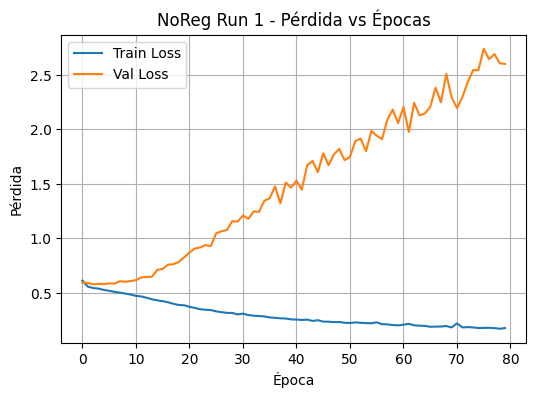

[NoReg Run 1] Diagnóstico: overfitting

[NoReg Run 2] Config (sin reg): {'hidden_sizes': (512, 256), 'lr': 0.001, 'epochs': 80, 'batch_size': 512}


/tmp/ipython-input-3353149371.py:48: RuntimeWarning: overflow encountered in exp
  y_true = torch.cat(all_y).numpy(); probs = 1/(1+np.exp(-torch.cat(all_logits).numpy()))


[NoReg Run 2][Ep 001] TrainLoss=0.6065 Acc=0.800 | ValLoss=0.5805 Acc=0.805
[NoReg Run 2][Ep 002] TrainLoss=0.5549 Acc=0.814 | ValLoss=0.5824 Acc=0.790
[NoReg Run 2][Ep 003] TrainLoss=0.5455 Acc=0.815 | ValLoss=0.5838 Acc=0.814
[NoReg Run 2][Ep 004] TrainLoss=0.5360 Acc=0.820 | ValLoss=0.5986 Acc=0.830
[NoReg Run 2][Ep 005] TrainLoss=0.5293 Acc=0.822 | ValLoss=0.5829 Acc=0.816
[NoReg Run 2][Ep 006] TrainLoss=0.5181 Acc=0.827 | ValLoss=0.5805 Acc=0.809
[NoReg Run 2][Ep 007] TrainLoss=0.5120 Acc=0.827 | ValLoss=0.5832 Acc=0.810
[NoReg Run 2][Ep 008] TrainLoss=0.5026 Acc=0.831 | ValLoss=0.5905 Acc=0.813
[NoReg Run 2][Ep 009] TrainLoss=0.4928 Acc=0.833 | ValLoss=0.6038 Acc=0.820
[NoReg Run 2][Ep 010] TrainLoss=0.4891 Acc=0.835 | ValLoss=0.6347 Acc=0.822
[NoReg Run 2][Ep 011] TrainLoss=0.4796 Acc=0.838 | ValLoss=0.6100 Acc=0.814
[NoReg Run 2][Ep 012] TrainLoss=0.4693 Acc=0.842 | ValLoss=0.6139 Acc=0.791
[NoReg Run 2][Ep 013] TrainLoss=0.4610 Acc=0.845 | ValLoss=0.6314 Acc=0.814
[NoReg Run 2

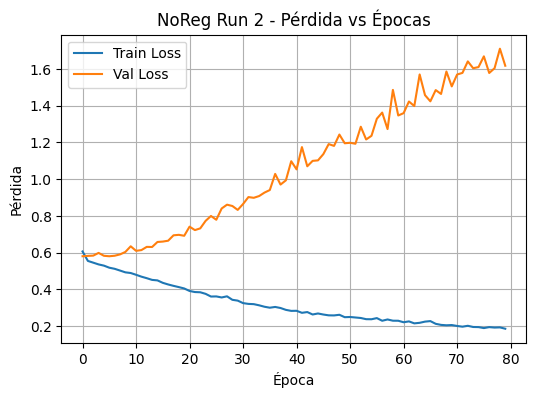

[NoReg Run 2] Diagnóstico: overfitting

[NoReg Run 3] Config (sin reg): {'hidden_sizes': (256, 256, 128), 'lr': 0.0008, 'epochs': 100, 'batch_size': 256}


/tmp/ipython-input-3353149371.py:48: RuntimeWarning: overflow encountered in exp
  y_true = torch.cat(all_y).numpy(); probs = 1/(1+np.exp(-torch.cat(all_logits).numpy()))


[NoReg Run 3][Ep 001] TrainLoss=0.6053 Acc=0.791 | ValLoss=0.5860 Acc=0.798
[NoReg Run 3][Ep 002] TrainLoss=0.5546 Acc=0.814 | ValLoss=0.5832 Acc=0.794
[NoReg Run 3][Ep 003] TrainLoss=0.5469 Acc=0.814 | ValLoss=0.5859 Acc=0.804
[NoReg Run 3][Ep 004] TrainLoss=0.5358 Acc=0.818 | ValLoss=0.5899 Acc=0.793
[NoReg Run 3][Ep 005] TrainLoss=0.5220 Acc=0.825 | ValLoss=0.5969 Acc=0.806
[NoReg Run 3][Ep 006] TrainLoss=0.5136 Acc=0.826 | ValLoss=0.5885 Acc=0.792
[NoReg Run 3][Ep 007] TrainLoss=0.5027 Acc=0.830 | ValLoss=0.5963 Acc=0.799
[NoReg Run 3][Ep 008] TrainLoss=0.4922 Acc=0.832 | ValLoss=0.6162 Acc=0.814
[NoReg Run 3][Ep 009] TrainLoss=0.4798 Acc=0.835 | ValLoss=0.6395 Acc=0.822
[NoReg Run 3][Ep 010] TrainLoss=0.4691 Acc=0.837 | ValLoss=0.6535 Acc=0.810
[NoReg Run 3][Ep 011] TrainLoss=0.4614 Acc=0.842 | ValLoss=0.6334 Acc=0.791
[NoReg Run 3][Ep 012] TrainLoss=0.4439 Acc=0.846 | ValLoss=0.6483 Acc=0.793
[NoReg Run 3][Ep 013] TrainLoss=0.4349 Acc=0.848 | ValLoss=0.6788 Acc=0.815
[NoReg Run 3

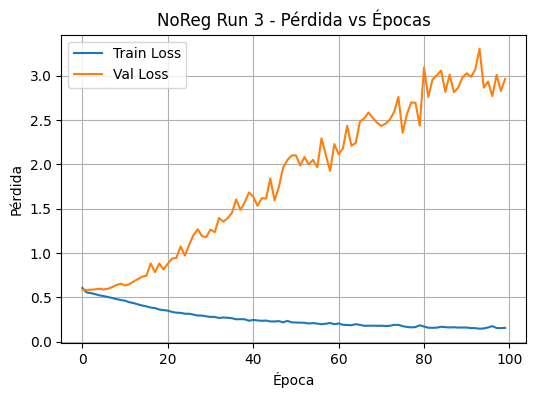

[NoReg Run 3] Diagnóstico: overfitting

[NoReg Run 4] Config (sin reg): {'hidden_sizes': (384, 192, 96), 'lr': 0.0015, 'epochs': 80, 'batch_size': 256}


/tmp/ipython-input-3353149371.py:48: RuntimeWarning: overflow encountered in exp
  y_true = torch.cat(all_y).numpy(); probs = 1/(1+np.exp(-torch.cat(all_logits).numpy()))


[NoReg Run 4][Ep 001] TrainLoss=0.5990 Acc=0.797 | ValLoss=0.6074 Acc=0.831
[NoReg Run 4][Ep 002] TrainLoss=0.5534 Acc=0.812 | ValLoss=0.5808 Acc=0.794
[NoReg Run 4][Ep 003] TrainLoss=0.5421 Acc=0.817 | ValLoss=0.5801 Acc=0.800
[NoReg Run 4][Ep 004] TrainLoss=0.5268 Acc=0.820 | ValLoss=0.5873 Acc=0.800
[NoReg Run 4][Ep 005] TrainLoss=0.5167 Acc=0.825 | ValLoss=0.5933 Acc=0.764
[NoReg Run 4][Ep 006] TrainLoss=0.5058 Acc=0.826 | ValLoss=0.5995 Acc=0.801
[NoReg Run 4][Ep 007] TrainLoss=0.4938 Acc=0.828 | ValLoss=0.5991 Acc=0.799
[NoReg Run 4][Ep 008] TrainLoss=0.4843 Acc=0.831 | ValLoss=0.6140 Acc=0.796
[NoReg Run 4][Ep 009] TrainLoss=0.4672 Acc=0.838 | ValLoss=0.6301 Acc=0.790
[NoReg Run 4][Ep 010] TrainLoss=0.4561 Acc=0.840 | ValLoss=0.6339 Acc=0.790
[NoReg Run 4][Ep 011] TrainLoss=0.4419 Acc=0.842 | ValLoss=0.6904 Acc=0.811
[NoReg Run 4][Ep 012] TrainLoss=0.4295 Acc=0.847 | ValLoss=0.7479 Acc=0.814
[NoReg Run 4][Ep 013] TrainLoss=0.4170 Acc=0.852 | ValLoss=0.7449 Acc=0.808
[NoReg Run 4

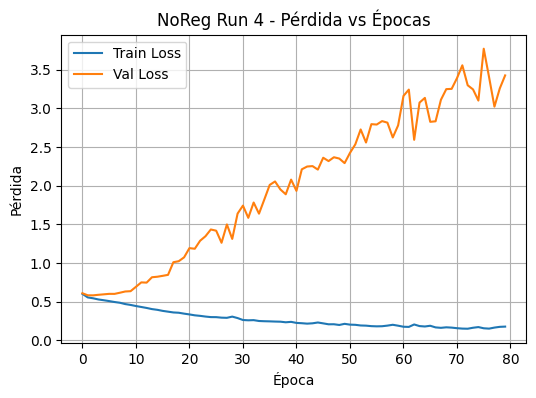

[NoReg Run 4] Diagnóstico: overfitting

[NoReg Run 5] Config (sin reg): {'hidden_sizes': (512, 256, 128, 64), 'lr': 0.0007, 'epochs': 100, 'batch_size': 256}


/tmp/ipython-input-3353149371.py:48: RuntimeWarning: overflow encountered in exp
  y_true = torch.cat(all_y).numpy(); probs = 1/(1+np.exp(-torch.cat(all_logits).numpy()))


[NoReg Run 5][Ep 001] TrainLoss=0.5939 Acc=0.798 | ValLoss=0.5811 Acc=0.800
[NoReg Run 5][Ep 002] TrainLoss=0.5542 Acc=0.812 | ValLoss=0.5856 Acc=0.819
[NoReg Run 5][Ep 003] TrainLoss=0.5428 Acc=0.817 | ValLoss=0.5860 Acc=0.781
[NoReg Run 5][Ep 004] TrainLoss=0.5312 Acc=0.819 | ValLoss=0.5794 Acc=0.790
[NoReg Run 5][Ep 005] TrainLoss=0.5191 Acc=0.823 | ValLoss=0.6003 Acc=0.821
[NoReg Run 5][Ep 006] TrainLoss=0.5078 Acc=0.827 | ValLoss=0.6072 Acc=0.809
[NoReg Run 5][Ep 007] TrainLoss=0.4983 Acc=0.829 | ValLoss=0.6334 Acc=0.823
[NoReg Run 5][Ep 008] TrainLoss=0.4919 Acc=0.831 | ValLoss=0.6028 Acc=0.797
[NoReg Run 5][Ep 009] TrainLoss=0.4712 Acc=0.836 | ValLoss=0.6374 Acc=0.821
[NoReg Run 5][Ep 010] TrainLoss=0.4613 Acc=0.839 | ValLoss=0.6571 Acc=0.807
[NoReg Run 5][Ep 011] TrainLoss=0.4489 Acc=0.841 | ValLoss=0.6639 Acc=0.786
[NoReg Run 5][Ep 012] TrainLoss=0.4347 Acc=0.845 | ValLoss=0.6750 Acc=0.771
[NoReg Run 5][Ep 013] TrainLoss=0.4223 Acc=0.849 | ValLoss=0.7818 Acc=0.823
[NoReg Run 5

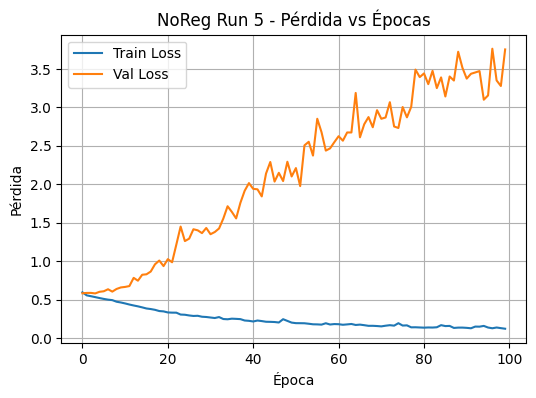

[NoReg Run 5] Diagnóstico: overfitting

[Run 1] Config: {'hidden_sizes': (256, 128, 64), 'dropout_p': 0.3, 'use_batchnorm': True, 'lr': 0.001, 'weight_decay': 0.0003, 'epochs': 80, 'batch_size': 256, 'grad_clip': 2.0, 'pos_weight_factor': 1.0}


/tmp/ipython-input-3353149371.py:48: RuntimeWarning: overflow encountered in exp
  y_true = torch.cat(all_y).numpy(); probs = 1/(1+np.exp(-torch.cat(all_logits).numpy()))


[Run 1][Ep 001] TrainLoss=0.6980 Acc=0.761 | ValLoss=0.5892 Acc=0.781 | LR=1.00e-03 ← best
[Run 1][Ep 002] TrainLoss=0.6090 Acc=0.797 | ValLoss=0.5782 Acc=0.797 | LR=1.00e-03 ← best
[Run 1][Ep 003] TrainLoss=0.5917 Acc=0.797 | ValLoss=0.5783 Acc=0.794 | LR=1.00e-03 
[Run 1][Ep 004] TrainLoss=0.5809 Acc=0.801 | ValLoss=0.5765 Acc=0.794 | LR=1.00e-03 ← best
[Run 1][Ep 005] TrainLoss=0.5750 Acc=0.803 | ValLoss=0.5771 Acc=0.802 | LR=1.00e-03 
[Run 1][Ep 006] TrainLoss=0.5664 Acc=0.809 | ValLoss=0.5763 Acc=0.796 | LR=1.00e-03 ← best
[Run 1][Ep 007] TrainLoss=0.5674 Acc=0.806 | ValLoss=0.5737 Acc=0.793 | LR=1.00e-03 ← best
[Run 1][Ep 008] TrainLoss=0.5596 Acc=0.810 | ValLoss=0.5750 Acc=0.802 | LR=1.00e-03 
[Run 1][Ep 009] TrainLoss=0.5605 Acc=0.810 | ValLoss=0.5754 Acc=0.798 | LR=1.00e-03 
[Run 1][Ep 010] TrainLoss=0.5589 Acc=0.811 | ValLoss=0.5755 Acc=0.791 | LR=5.00e-04 
[Run 1][Ep 011] TrainLoss=0.5524 Acc=0.811 | ValLoss=0.5766 Acc=0.802 | LR=5.00e-04 
[Run 1][Ep 012] TrainLoss=0.5479 Ac

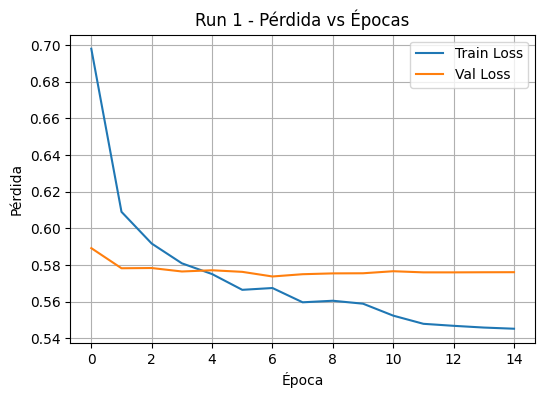

[Run 1] Diagnóstico: ajuste_razonable

[Run 2] Config: {'hidden_sizes': (512, 256), 'dropout_p': 0.2, 'use_batchnorm': True, 'lr': 0.001, 'weight_decay': 0.001, 'epochs': 80, 'batch_size': 512, 'grad_clip': 2.0, 'pos_weight_factor': 1.0}
[Run 2][Ep 001] TrainLoss=0.6382 Acc=0.786 | ValLoss=0.5854 Acc=0.792 | LR=1.00e-03 ← best
[Run 2][Ep 002] TrainLoss=0.5759 Acc=0.807 | ValLoss=0.5785 Acc=0.803 | LR=1.00e-03 ← best
[Run 2][Ep 003] TrainLoss=0.5643 Acc=0.811 | ValLoss=0.5842 Acc=0.797 | LR=1.00e-03 
[Run 2][Ep 004] TrainLoss=0.5525 Acc=0.813 | ValLoss=0.5820 Acc=0.808 | LR=1.00e-03 
[Run 2][Ep 005] TrainLoss=0.5470 Acc=0.816 | ValLoss=0.5776 Acc=0.792 | LR=1.00e-03 ← best
[Run 2][Ep 006] TrainLoss=0.5409 Acc=0.818 | ValLoss=0.5785 Acc=0.797 | LR=1.00e-03 
[Run 2][Ep 007] TrainLoss=0.5369 Acc=0.821 | ValLoss=0.5781 Acc=0.798 | LR=1.00e-03 
[Run 2][Ep 008] TrainLoss=0.5319 Acc=0.818 | ValLoss=0.5799 Acc=0.801 | LR=5.00e-04 
[Run 2][Ep 009] TrainLoss=0.5234 Acc=0.825 | ValLoss=0.5781 Acc=

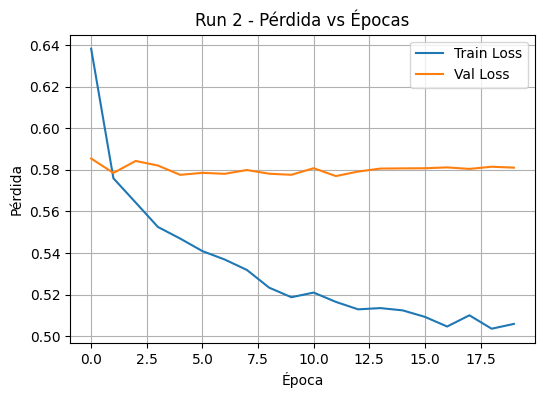

[Run 2] Diagnóstico: ajuste_razonable

[Run 3] Config: {'hidden_sizes': (256, 128, 64), 'dropout_p': 0.5, 'use_batchnorm': False, 'lr': 0.0008, 'weight_decay': 0.0005, 'epochs': 80, 'batch_size': 256, 'grad_clip': 2.0, 'pos_weight_factor': 1.0}
[Run 3][Ep 001] TrainLoss=0.7949 Acc=0.729 | ValLoss=0.6154 Acc=0.764 | LR=8.00e-04 ← best
[Run 3][Ep 002] TrainLoss=0.6523 Acc=0.780 | ValLoss=0.5943 Acc=0.792 | LR=8.00e-04 ← best
[Run 3][Ep 003] TrainLoss=0.6310 Acc=0.787 | ValLoss=0.5907 Acc=0.788 | LR=8.00e-04 ← best
[Run 3][Ep 004] TrainLoss=0.6109 Acc=0.791 | ValLoss=0.5858 Acc=0.790 | LR=8.00e-04 ← best
[Run 3][Ep 005] TrainLoss=0.6011 Acc=0.796 | ValLoss=0.5807 Acc=0.793 | LR=8.00e-04 ← best
[Run 3][Ep 006] TrainLoss=0.5940 Acc=0.801 | ValLoss=0.5839 Acc=0.794 | LR=8.00e-04 
[Run 3][Ep 007] TrainLoss=0.5876 Acc=0.802 | ValLoss=0.5817 Acc=0.780 | LR=8.00e-04 
[Run 3][Ep 008] TrainLoss=0.5850 Acc=0.802 | ValLoss=0.5806 Acc=0.795 | LR=8.00e-04 ← best
[Run 3][Ep 009] TrainLoss=0.5824 Acc=0.

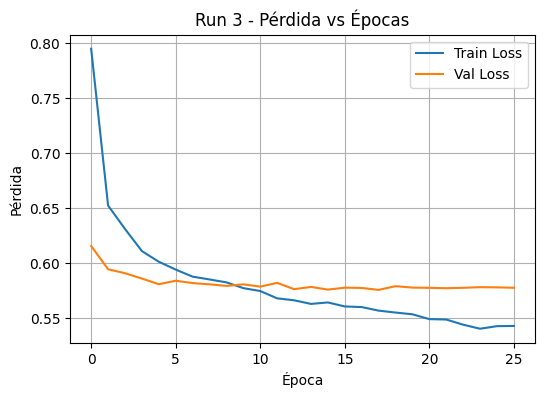

[Run 3] Diagnóstico: ajuste_razonable

[Run 4] Config: {'hidden_sizes': (384, 192, 96), 'dropout_p': 0.3, 'use_batchnorm': True, 'lr': 0.002, 'weight_decay': 0.0001, 'epochs': 80, 'batch_size': 256, 'grad_clip': 2.0, 'pos_weight_factor': 1.2}
[Run 4][Ep 001] TrainLoss=0.7017 Acc=0.769 | ValLoss=0.6311 Acc=0.781 | LR=2.00e-03 ← best
[Run 4][Ep 002] TrainLoss=0.6339 Acc=0.791 | ValLoss=0.6313 Acc=0.780 | LR=2.00e-03 
[Run 4][Ep 003] TrainLoss=0.6220 Acc=0.792 | ValLoss=0.6268 Acc=0.797 | LR=2.00e-03 ← best
[Run 4][Ep 004] TrainLoss=0.6133 Acc=0.793 | ValLoss=0.6273 Acc=0.783 | LR=2.00e-03 
[Run 4][Ep 005] TrainLoss=0.6036 Acc=0.801 | ValLoss=0.6283 Acc=0.792 | LR=2.00e-03 
[Run 4][Ep 006] TrainLoss=0.6049 Acc=0.797 | ValLoss=0.6292 Acc=0.779 | LR=1.00e-03 
[Run 4][Ep 007] TrainLoss=0.5905 Acc=0.802 | ValLoss=0.6301 Acc=0.785 | LR=1.00e-03 
[Run 4][Ep 008] TrainLoss=0.5858 Acc=0.803 | ValLoss=0.6312 Acc=0.789 | LR=1.00e-03 
[Run 4][Ep 009] TrainLoss=0.5847 Acc=0.804 | ValLoss=0.6321 Acc=0

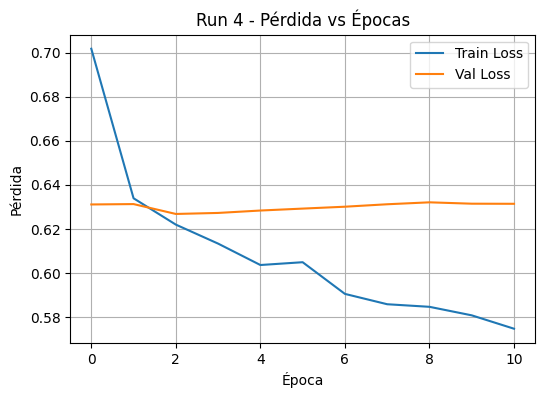

[Run 4] Diagnóstico: ajuste_razonable

[Run 5] Config: {'hidden_sizes': (512, 256, 128, 64), 'dropout_p': 0.3, 'use_batchnorm': True, 'lr': 0.0007, 'weight_decay': 0.0005, 'epochs': 100, 'batch_size': 256, 'grad_clip': 2.0, 'pos_weight_factor': 1.0}
[Run 5][Ep 001] TrainLoss=0.6999 Acc=0.767 | ValLoss=0.5914 Acc=0.781 | LR=7.00e-04 ← best
[Run 5][Ep 002] TrainLoss=0.6074 Acc=0.799 | ValLoss=0.5770 Acc=0.799 | LR=7.00e-04 ← best
[Run 5][Ep 003] TrainLoss=0.5932 Acc=0.798 | ValLoss=0.5776 Acc=0.788 | LR=7.00e-04 
[Run 5][Ep 004] TrainLoss=0.5803 Acc=0.801 | ValLoss=0.5769 Acc=0.797 | LR=7.00e-04 ← best
[Run 5][Ep 005] TrainLoss=0.5747 Acc=0.807 | ValLoss=0.5767 Acc=0.788 | LR=7.00e-04 ← best
[Run 5][Ep 006] TrainLoss=0.5689 Acc=0.803 | ValLoss=0.5750 Acc=0.793 | LR=7.00e-04 ← best
[Run 5][Ep 007] TrainLoss=0.5652 Acc=0.807 | ValLoss=0.5762 Acc=0.796 | LR=7.00e-04 
[Run 5][Ep 008] TrainLoss=0.5606 Acc=0.807 | ValLoss=0.5753 Acc=0.800 | LR=7.00e-04 
[Run 5][Ep 009] TrainLoss=0.5583 Acc=0.8

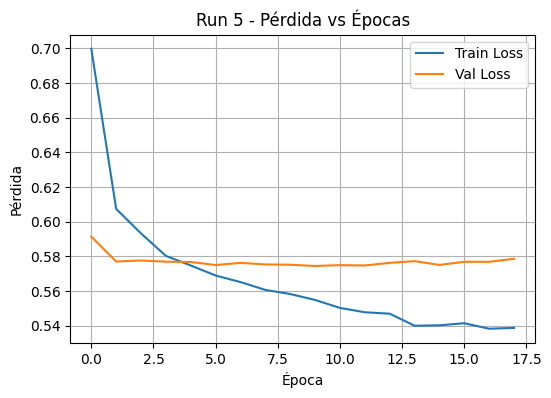

[Run 5] Diagnóstico: ajuste_razonable

==== Resumen SIN Regularización ====
            hidden_sizes   bs  epochs_trained  best_val_loss  best_epoch  \
run                                                                        
1         (256, 128, 64)  256              80         0.5790           3   
2             (512, 256)  512              80         0.5805           6   
3        (256, 256, 128)  256             100         0.5832           2   
4         (384, 192, 96)  256              80         0.5801           3   
5    (512, 256, 128, 64)  256             100         0.5794           4   

     test_acc@0.5    diagnosis      lr  
run                                     
1          0.8085  overfitting  0.0010  
2          0.8092  overfitting  0.0010  
3          0.8161  overfitting  0.0008  
4          0.8202  overfitting  0.0015  
5          0.8193  overfitting  0.0007  

==== Resumen CON Regularización ====
            hidden_sizes   bs  epochs_trained  best_val_loss  best

In [ ]:
# SIN regularización (para comparación)
noreg_experiments = [
    {"hidden_sizes": (256,128,64), "lr": 1e-3,  "epochs": 80,  "batch_size": 256},
    {"hidden_sizes": (512,256),    "lr": 1e-3,  "epochs": 80,  "batch_size": 512},
    {"hidden_sizes": (256,256,128),"lr": 8e-4,  "epochs": 100, "batch_size": 256},
    {"hidden_sizes": (384,192,96), "lr": 1.5e-3,"epochs": 80,  "batch_size": 256},
    {"hidden_sizes": (512,256,128,64),"lr": 7e-4,"epochs": 100,"batch_size": 256},
]

# CON regularización
experiments = [
    {"hidden_sizes": (256,128,64), "dropout_p": 0.3, "use_batchnorm": True,
     "lr": 1e-3, "weight_decay": 3e-4, "epochs": 80, "batch_size": 256, "grad_clip": 2.0, "pos_weight_factor": 1.0},

    {"hidden_sizes": (512,256), "dropout_p": 0.2, "use_batchnorm": True,
     "lr": 1e-3, "weight_decay": 1e-3, "epochs": 80, "batch_size": 512, "grad_clip": 2.0, "pos_weight_factor": 1.0},

    {"hidden_sizes": (256,128,64), "dropout_p": 0.5, "use_batchnorm": False,
     "lr": 8e-4, "weight_decay": 5e-4, "epochs": 80, "batch_size": 256, "grad_clip": 2.0, "pos_weight_factor": 1.0},

    {"hidden_sizes": (384,192,96), "dropout_p": 0.3, "use_batchnorm": True,
     "lr": 2e-3, "weight_decay": 1e-4, "epochs": 80, "batch_size": 256, "grad_clip": 2.0, "pos_weight_factor": 1.2},

    {"hidden_sizes": (512,256,128,64), "dropout_p": 0.3, "use_batchnorm": True,
     "lr": 7e-4, "weight_decay": 5e-4, "epochs": 100, "batch_size": 256, "grad_clip": 2.0, "pos_weight_factor": 1.0},
]

# Ejecutar y resumir
noreg_results = [train_one_experiment_noreg(cfg, i) for i,cfg in enumerate(noreg_experiments,1)]
results      = [train_one_experiment(cfg, i)      for i,cfg in enumerate(experiments,1)]

def summarize(runs, with_reg: bool):
    rows=[]
    for r in runs:
        best_val = float(np.min(r["history"]["val_loss"]))
        best_ep  = int(np.argmin(r["history"]["val_loss"])) + 1
        row = {
            "run": r["run_id"],
            "hidden_sizes": r["cfg"]["hidden_sizes"],
            "bs": r["cfg"]["batch_size"],
            "epochs_trained": len(r["history"]["val_loss"]),
            "best_val_loss": round(best_val,4),
            "best_epoch": best_ep,
            "test_acc@0.5": round(r["test_acc@0.5"],4),
            "diagnosis": r["diagnosis"],
        }
        if with_reg:
            row.update({
                "dropout": r["cfg"]["dropout_p"], "bn": r["cfg"]["use_batchnorm"],
                "lr": r["cfg"]["lr"], "wd": r["cfg"]["weight_decay"]
            })
        else:
            row.update({"lr": r["cfg"]["lr"]})
        rows.append(row)
    return pd.DataFrame(rows).set_index("run")

print("\n==== Resumen SIN Regularización ====")
print(summarize(noreg_results, with_reg=False))
print("\n==== Resumen CON Regularización ====")
print(summarize(results, with_reg=True))
